In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          655 non-null    object 
 1   Daily Confirmed                               655 non-null    int64  
 2   False Positives Found                         546 non-null    float64
 3   Cumulative Confirmed                          655 non-null    int64  
 4   Daily Discharged                              655 non-null    int64  
 5   Passed but not due to COVID                   655 non-null    int64  
 6   Cumulative Discharged                         655 non-null    int64  
 7   Discharged to Isolation                       655 non-null    int64  
 8   Still Hospitalised                            655 non-null    int64  
 9   Daily Deaths                                  655 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               655 non-null    int64  
 1   False Positives Found                         655 non-null    float64
 2   Cumulative Confirmed                          655 non-null    int64  
 3   Daily Discharged                              655 non-null    int64  
 4   Passed but not due to COVID                   655 non-null    int64  
 5   Cumulative Discharged                         655 non-null    int64  
 6   Discharged to Isolation                       655 non-null    int64  
 7   Still Hospitalised                            655 non-null    int64  
 8   Daily Deaths                                  655 non-null    int64  
 9   Cumulative Deaths                             655 non-null    int

<AxesSubplot:>

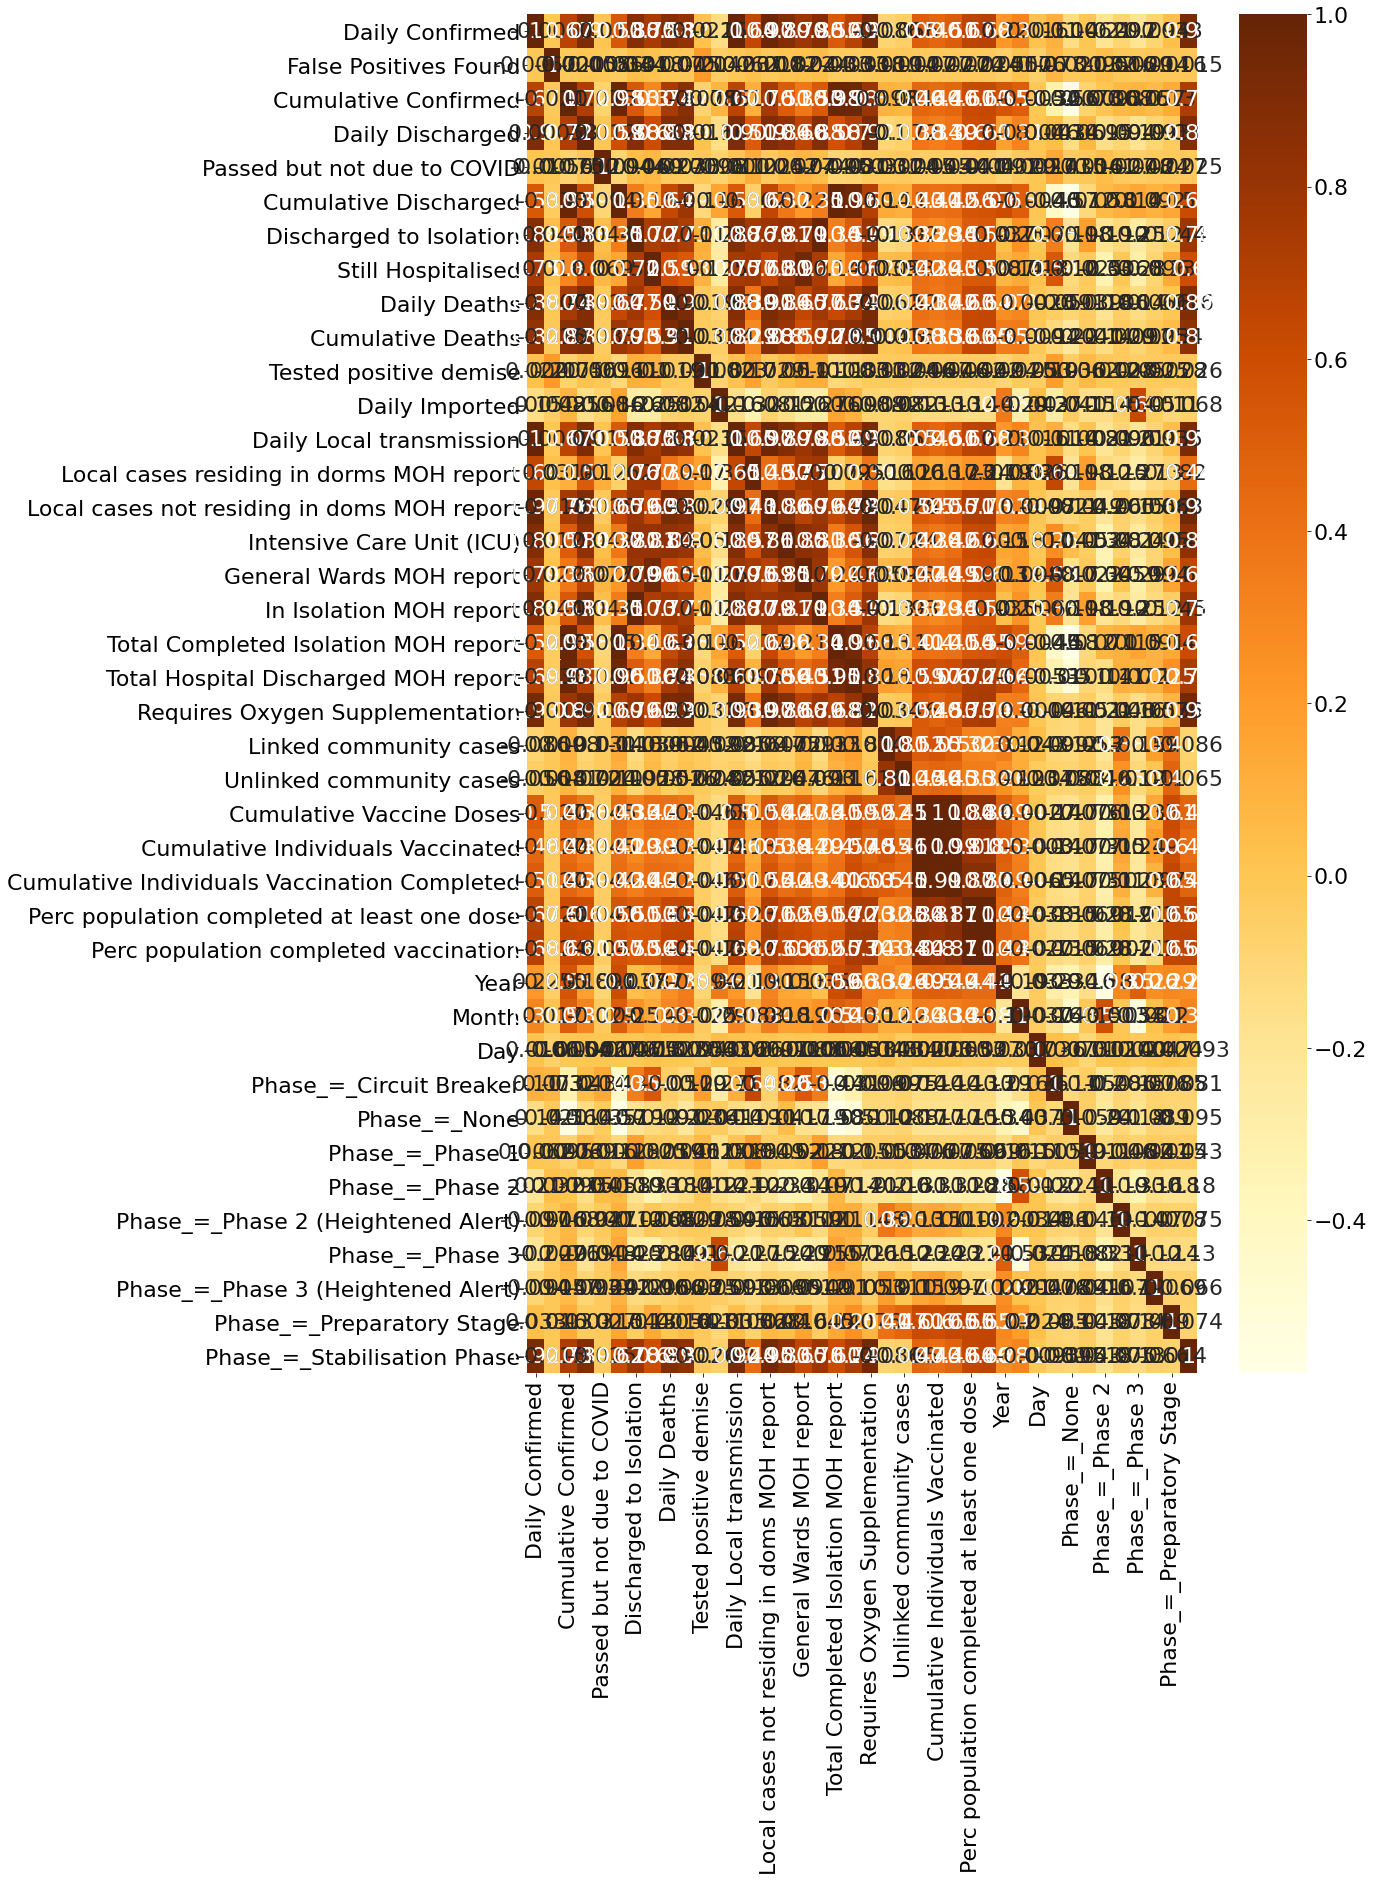

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to daily confirmed cases

sg_data_filtered.corr()["Daily Confirmed"].sort_values(ascending=False)

Daily Confirmed                                 1.000000
Daily Local transmission                        0.999933
Local cases not residing in doms MOH report     0.968292
Requires Oxygen Supplementation                 0.934163
Phase_=_Stabilisation Phase                     0.923459
Daily Discharged                                0.904233
Intensive Care Unit (ICU)                       0.887376
In Isolation MOH report                         0.883194
Discharged to Isolation                         0.881978
Daily Deaths                                    0.878718
Cumulative Deaths                               0.824953
General Wards MOH report                        0.790010
Still Hospitalised                              0.746101
Total Hospital Discharged MOH report            0.690230
Perc population completed vaccination           0.683900
Cumulative Confirmed                            0.673350
Perc population completed at least one dose     0.665334
Local cases residing in dorms M

In [16]:
# understanding correlation of all variables to imported cases

sg_data_filtered.corr()["Daily Imported"].sort_values(ascending=False)

Daily Imported                                  1.000000
Phase_=_Phase 3                                 0.624218
Year                                            0.362383
Total Completed Isolation MOH report            0.160947
Cumulative Discharged                           0.156761
Total Hospital Discharged MOH report            0.089780
Cumulative Confirmed                            0.084698
Day                                             0.043415
Phase_=_None                                   -0.040824
False Positives Found                          -0.041861
Phase_=_Phase 3 (Heightened Alert)             -0.050887
Cumulative Deaths                              -0.054484
Phase_=_Phase 2 (Heightened Alert)             -0.054494
Phase_=_Stabilisation Phase                    -0.068011
Passed but not due to COVID                    -0.080343
Local cases not residing in doms MOH report    -0.080615
Unlinked community cases                       -0.081653
Daily Deaths                   

In [17]:
# understanding correlation of all variables to vaccination rate

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998900
Cumulative Individuals Vaccination Completed    0.865359
Cumulative Vaccine Doses                        0.837851
Cumulative Individuals Vaccinated               0.802499
Requires Oxygen Supplementation                 0.743335
Total Hospital Discharged MOH report            0.732992
Local cases not residing in doms MOH report     0.728524
Daily Local transmission                        0.684310
Daily Confirmed                                 0.683900
Phase_=_Stabilisation Phase                     0.660387
Cumulative Deaths                               0.651967
Phase_=_Preparatory Stage                       0.651221
Daily Deaths                                    0.643793
Intensive Care Unit (ICU)                       0.633028
Cumulative Confirmed                            0.627150
Daily Discharged                                0.613796
General Wards MOH report       

In [18]:
# understanding correlation of all variables to ICU

sg_data_filtered.corr()["Intensive Care Unit (ICU)"].sort_values(ascending=False)

Intensive Care Unit (ICU)                       1.000000
Daily Local transmission                        0.887553
Daily Confirmed                                 0.887376
Requires Oxygen Supplementation                 0.876314
Local cases not residing in doms MOH report     0.859254
General Wards MOH report                        0.848649
Daily Deaths                                    0.844788
Daily Discharged                                0.835823
Phase_=_Stabilisation Phase                     0.834937
Still Hospitalised                              0.813277
In Isolation MOH report                         0.812856
Discharged to Isolation                         0.811333
Cumulative Deaths                               0.798370
Perc population completed vaccination           0.633028
Perc population completed at least one dose     0.617290
Local cases residing in dorms MOH report        0.569444
Total Hospital Discharged MOH report            0.555461
Cumulative Confirmed           

In [19]:
# understanding correlation of all variables to Oxygen Supplementation

sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.973238
Phase_=_Stabilisation Phase                     0.944620
Cumulative Deaths                               0.938153
Daily Confirmed                                 0.934163
Daily Local transmission                        0.933527
Daily Deaths                                    0.932141
Daily Discharged                                0.921066
Intensive Care Unit (ICU)                       0.876314
Total Hospital Discharged MOH report            0.817582
Cumulative Confirmed                            0.798024
Discharged to Isolation                         0.790795
In Isolation MOH report                         0.789981
Perc population completed vaccination           0.743335
Perc population completed at least one dose     0.726245
Cumulative Discharged                           0.693581
General Wards MOH report                        0.683431
Total Completed Isolation MOH r

# EDA - Viewing Chart Patterns

**Daily Confirmed Cases**

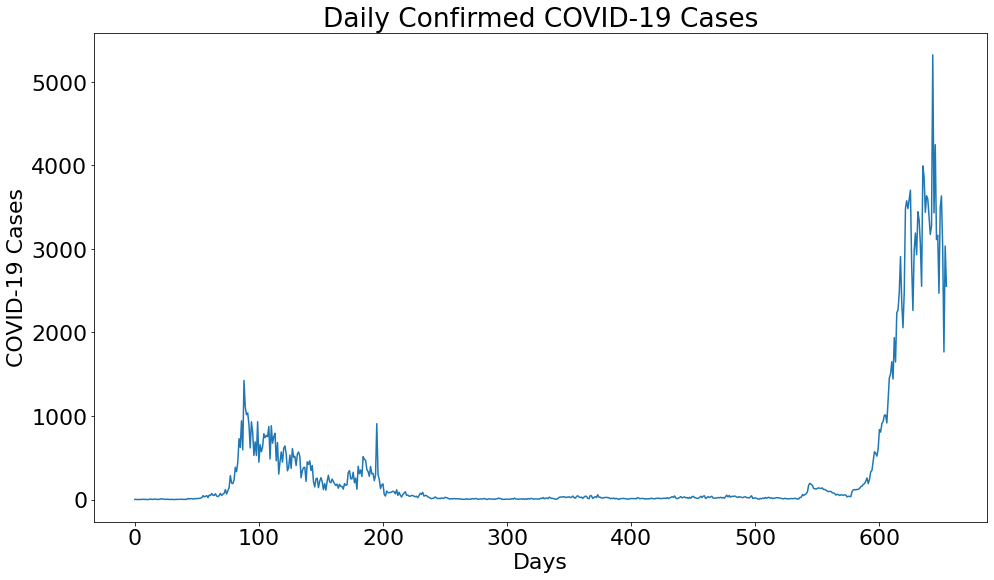

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Confirmed"].plot()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()

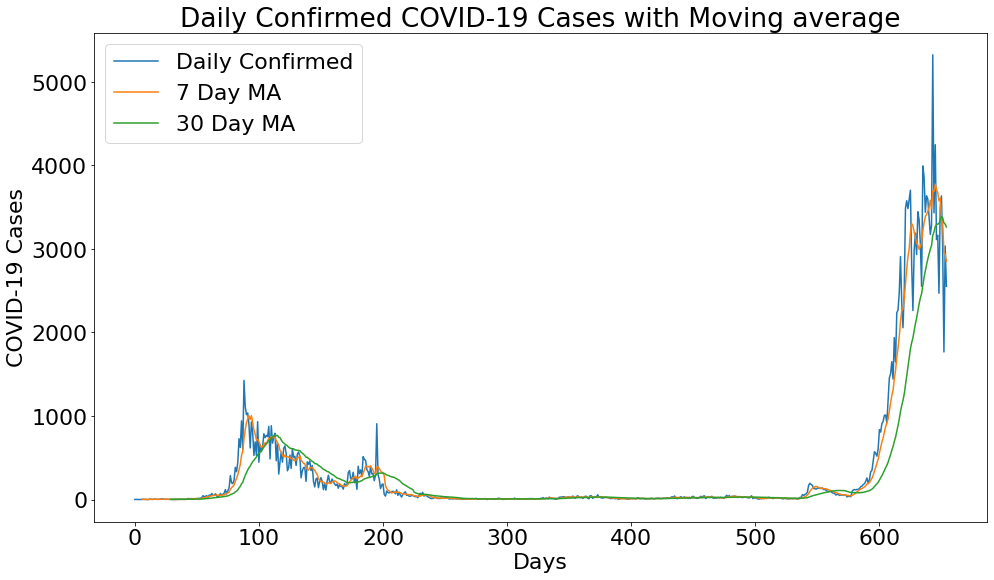

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Confirmed"], label="Daily Confirmed")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()

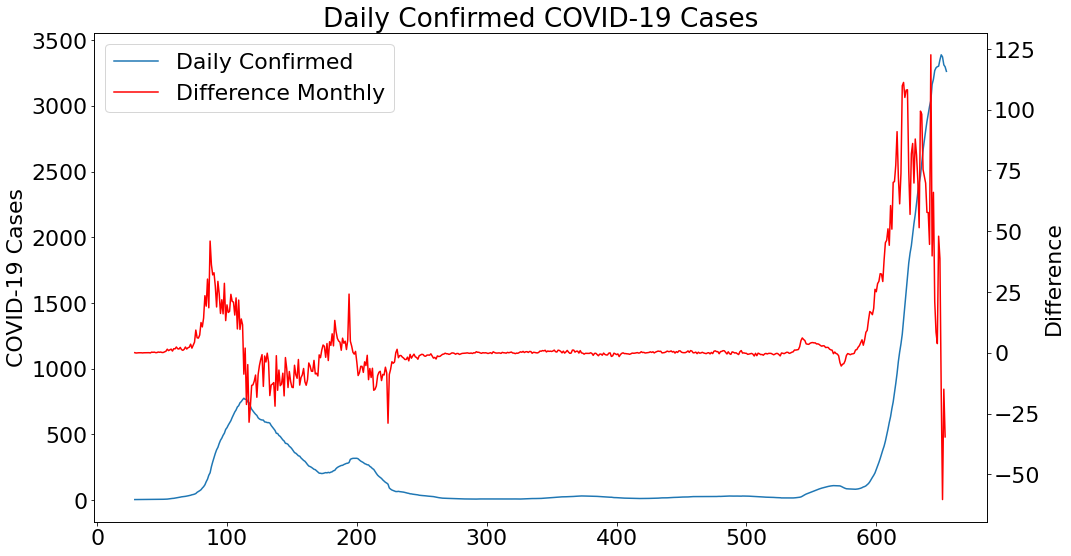

In [22]:
# shows inflection point

fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="Daily Confirmed")
ax.set_ylabel("COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.show()

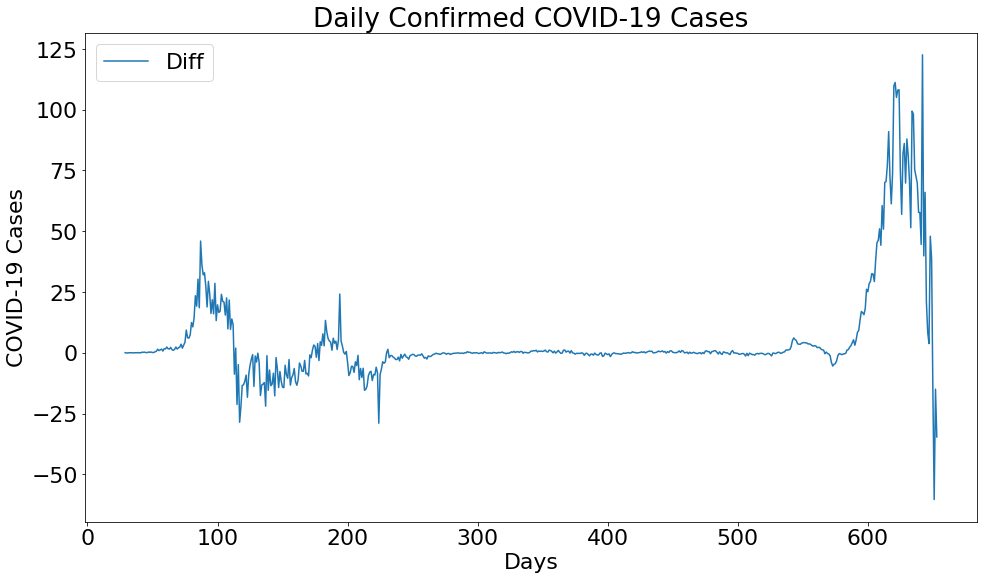

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Diff")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()

**Imported Cases**

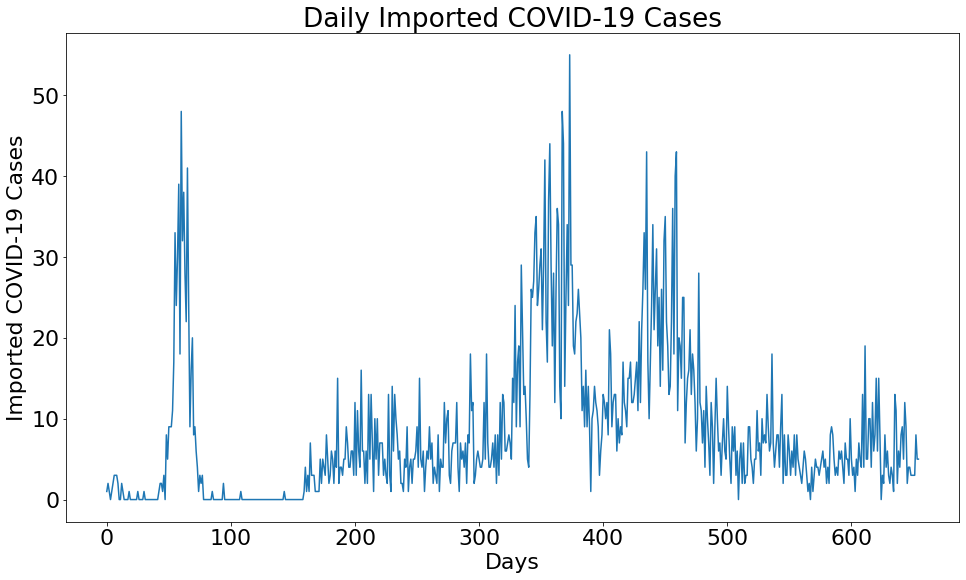

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Imported"].plot()
plt.title('Daily Imported COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('Imported COVID-19 Cases')
plt.show()

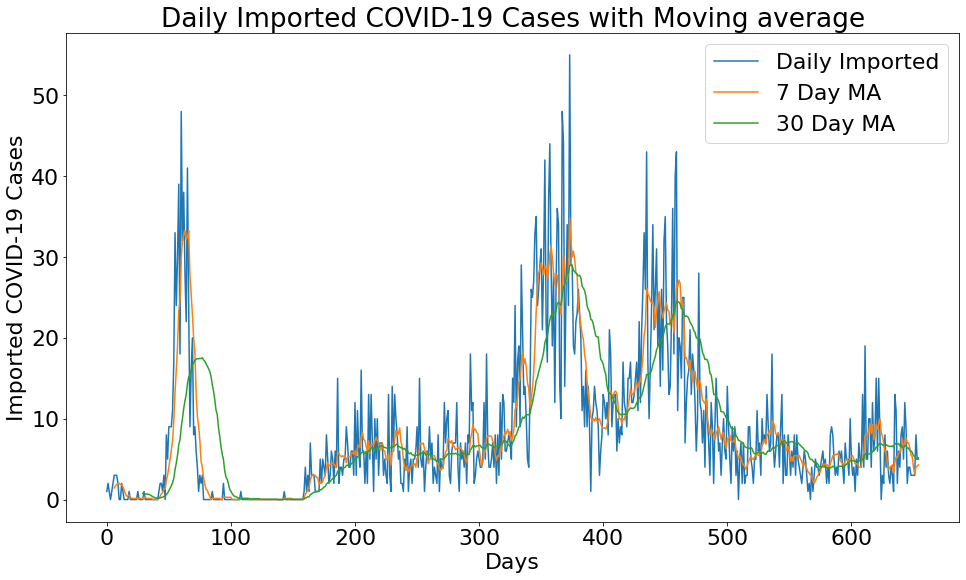

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Imported"], label="Daily Imported")
ax.plot(sg_data_filtered["Daily Imported"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Imported"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Imported COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('Imported COVID-19 Cases')
plt.show()

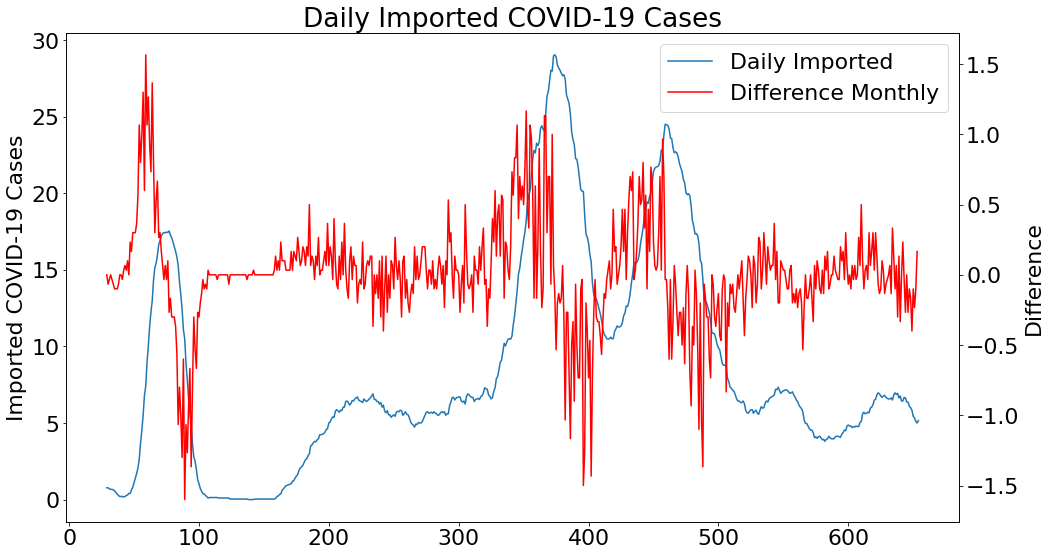

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Imported"].rolling(window=30).mean(), label="Daily Imported")
ax.set_ylabel("Imported COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Imported"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Imported COVID-19 Cases')
plt.xlabel('Days')
plt.show()

**Vaccination Rates**

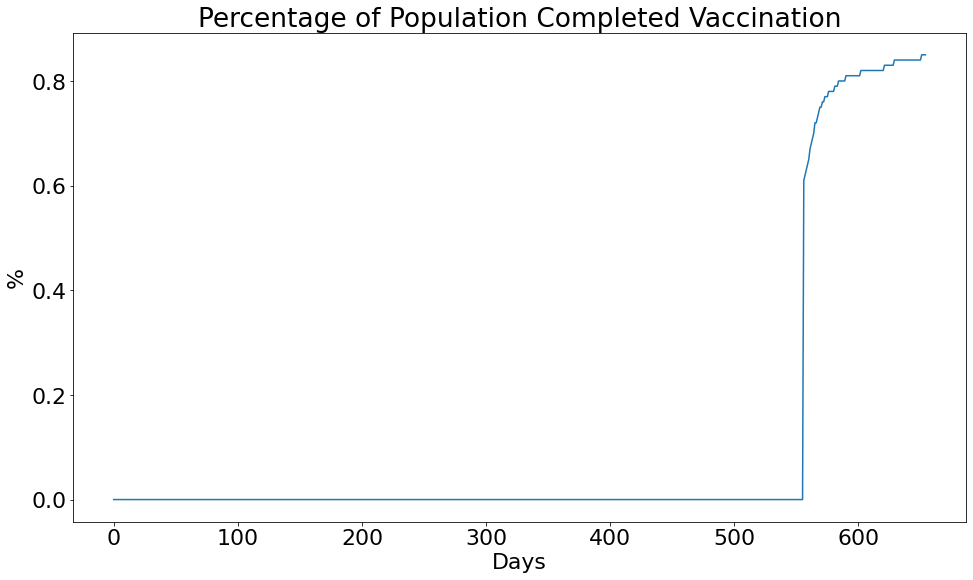

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Perc population completed vaccination"].plot()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

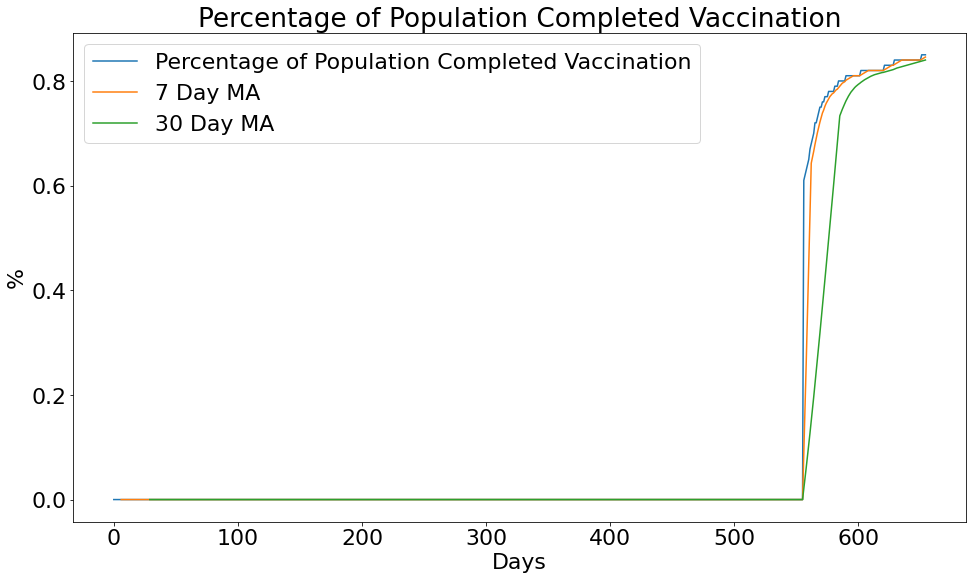

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Perc population completed vaccination"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

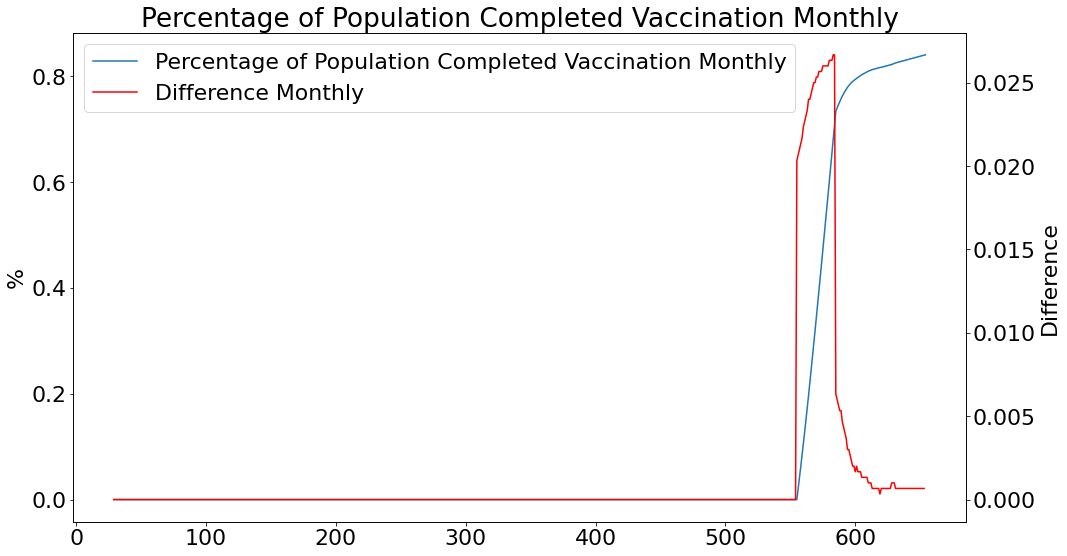

In [29]:
# shows inflection point

fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="Percentage of Population Completed Vaccination Monthly")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Completed Vaccination Monthly')
plt.xlabel('Days')
plt.show()

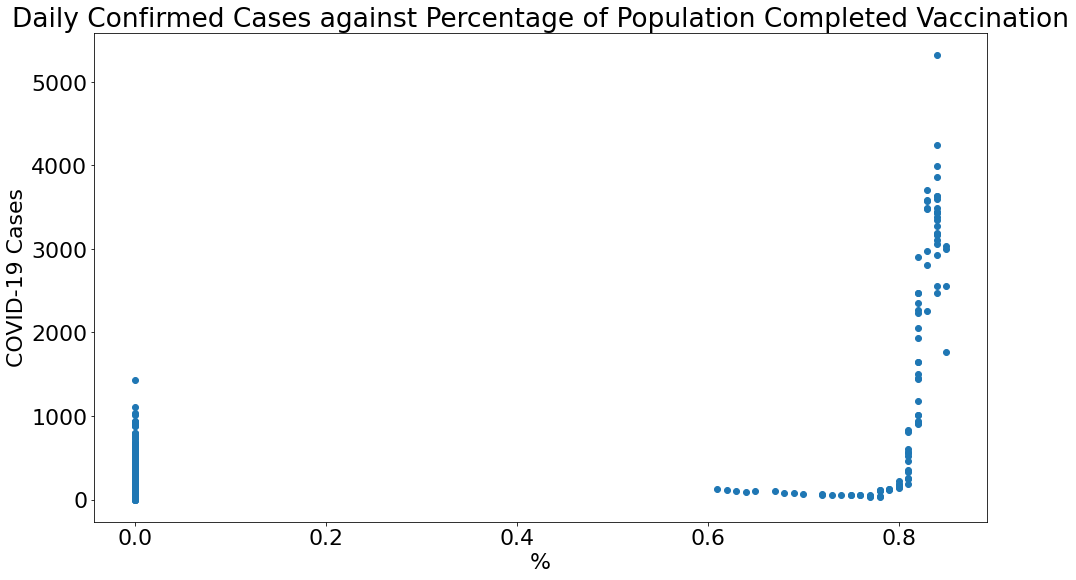

In [30]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Perc population completed vaccination"],sg_data_filtered["Daily Confirmed"])
plt.title('Daily Confirmed Cases against Percentage of Population Completed Vaccination')
plt.xlabel('%')
plt.ylabel('COVID-19 Cases')
plt.show()

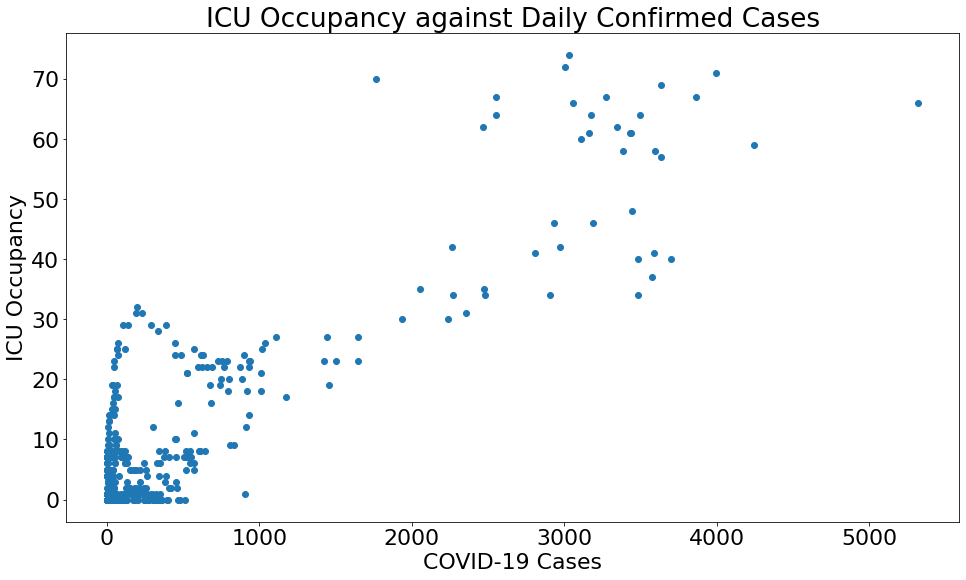

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()

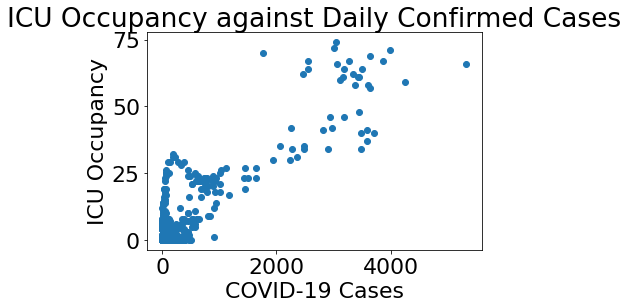

In [32]:
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()

**Oxygen Supplementation**

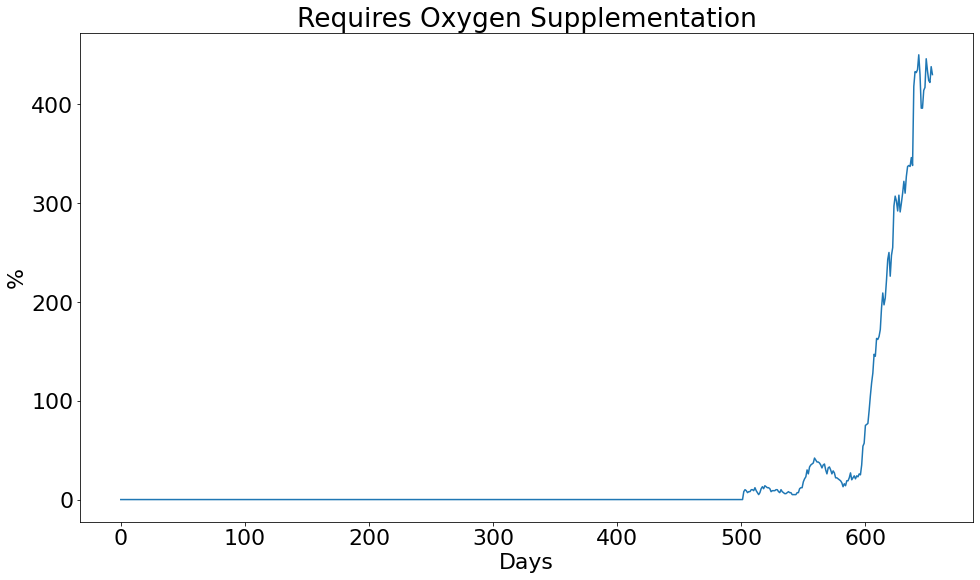

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Requires Oxygen Supplementation"].plot()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

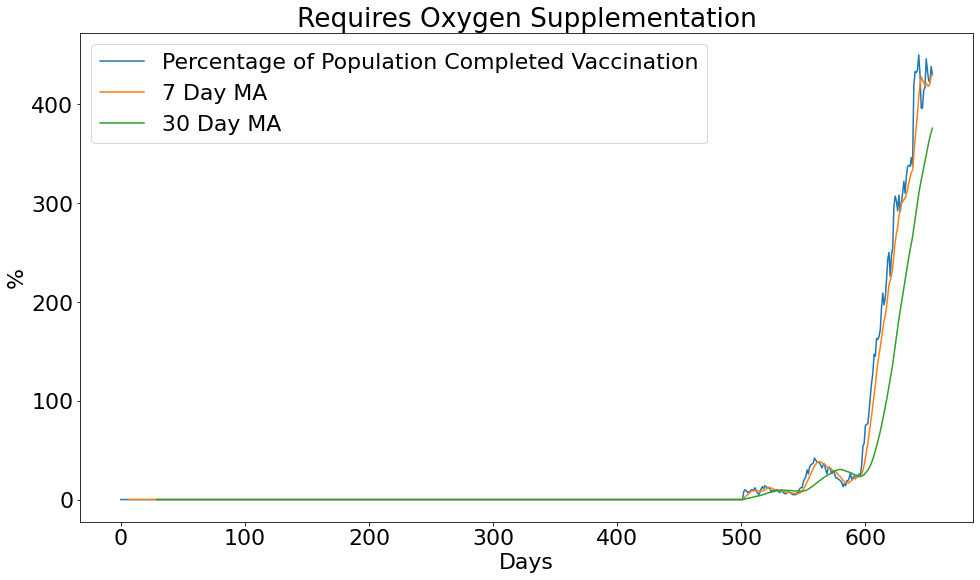

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

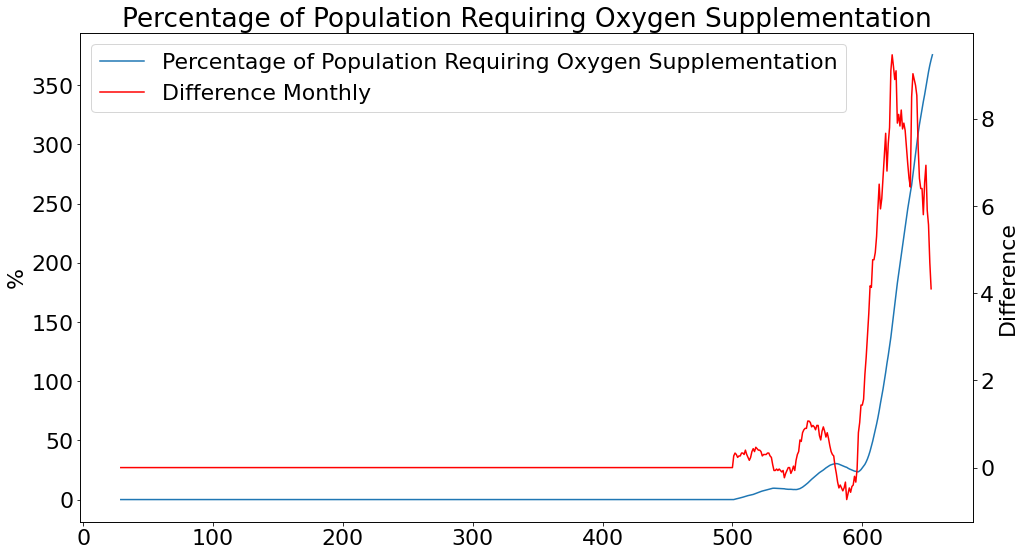

In [35]:
# shows inflection point

fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="Percentage of Population Requiring Oxygen Supplementation")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Requiring Oxygen Supplementation')
plt.xlabel('Days')
plt.show()

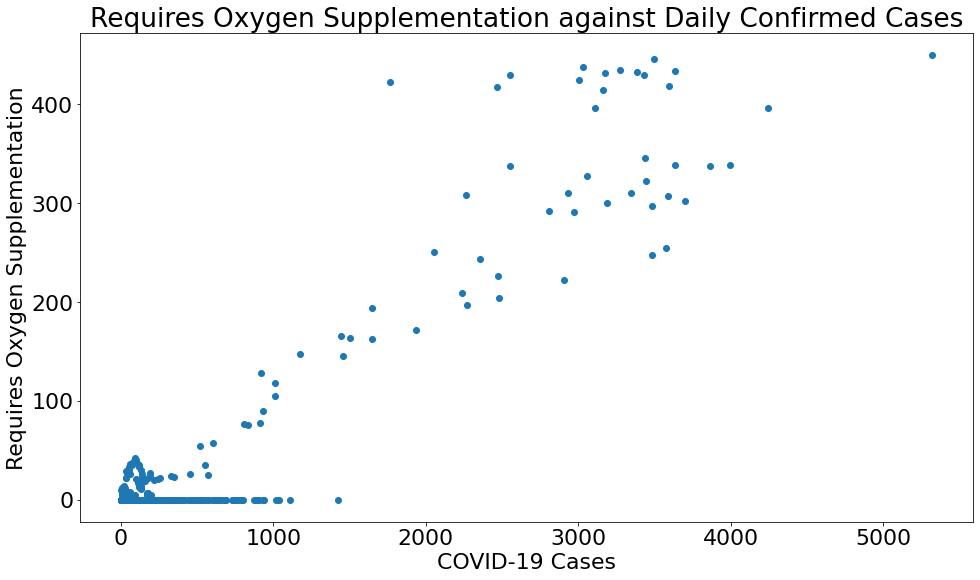

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Requires Oxygen Supplementation"])
plt.title('Requires Oxygen Supplementation against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('Requires Oxygen Supplementation')
plt.show()

# Model Building and Predictions

**Daily Confirmed Cases**

In [37]:
X = sg_data_filtered.drop("Daily Confirmed", axis=1)
y = sg_data_filtered["Daily Confirmed"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [40]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 2.1481705248114958e-10
MSE: 1.614963606530268e-19
RMSE: 4.018660979145004e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


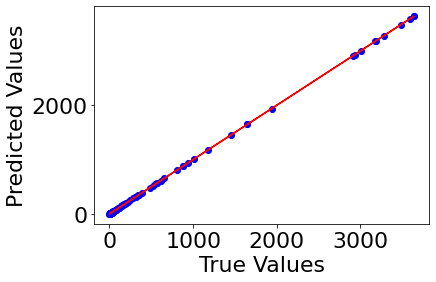

In [41]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

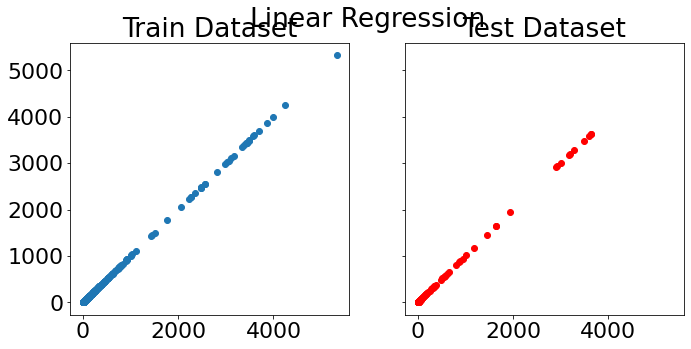

In [42]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [43]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.59805e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [44]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.00044817713464958663
MSE: 2.009091158868866e-06
RMSE: 0.0014174241280819463
R-squared score for train: 0.9999999999984327
Adjusted R-squared score for train: 0.9999999999983333
R-squared score for test: 0.9999999999974923
Adjusted R-squared score for test: 0.9999999999973334
Cross Validation Score: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.59805e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.25958e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.98987e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.16695e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99539e-17): result may not be accurate

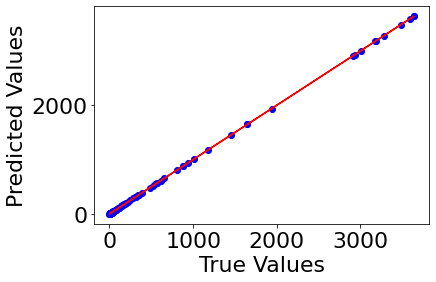

In [45]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

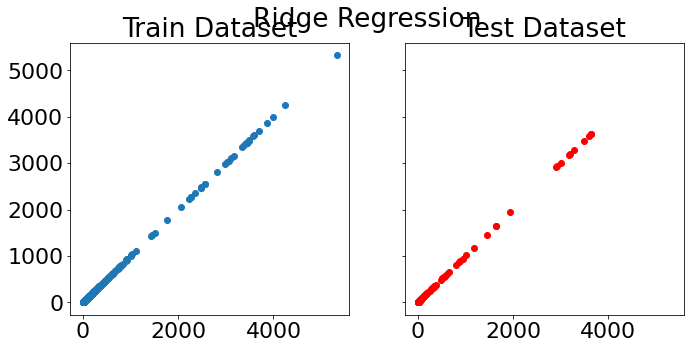

In [46]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [47]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
10,Daily Imported,9.999913e-01
11,Daily Local transmission,9.995321e-01
31,Phase_=_None,1.835113e-03
27,Year,6.519346e-04
13,Local cases not residing in doms MOH report,4.678746e-04
12,Local cases residing in dorms MOH report,4.672895e-04
1,Cumulative Confirmed,1.753667e-04
35,Phase_=_Phase 3,1.252992e-04
28,Month,8.107662e-05
14,Intensive Care Unit (ICU),6.032741e-05


In [48]:
# filter important features accordingly

important_X = X[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [49]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [50]:
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.0001927095297382681
MSE: 1.0866152494002241e-07
RMSE: 0.0003296384761219819
R-squared score for train: 0.9999999999998583
Adjusted R-squared score for train: 0.9999999999998552
R-squared score for test: 0.9999999999998643
Adjusted R-squared score for test: 0.9999999999998613
Cross Validation Score: 1.0


In [51]:
# XGBoost find best params

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.9,
 'min_child_weight': 4,
 'max_depth': 5,
 'colsample_bytree': 0.8}

In [52]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=5, colsample_bytree=0.8, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 21.831751321108285
MSE: 4105.413916340729
RMSE: 64.07350401172647
R-squared score for train: 0.9963366892159875
Adjusted R-squared score for train: 0.9962565542925872
R-squared score for test: 0.9948757556937862
Adjusted R-squared score for test: 0.9947636628495877
Cross Validation Score: 0.9936


In [53]:
future_prediction = pd.DataFrame(data={
    "Daily Imported":[0],
    "Daily Local transmission":[5000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([3940.9316], dtype=float32)

In [54]:
# without daily local transmission

important_X_wo = X[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train_wo = X_train[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test_wo = X_test[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [55]:
xgb2 = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=5, colsample_bytree=0.8, min_child_weight=6)
xgb2.fit(important_X_train_wo, y_train)
xgb_pred_wo = xgb2.predict(important_X_test_wo)
train_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_train_wo, y_train)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
test_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_test_wo, y_test)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred_wo)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred_wo)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred_wo))}")
print(f"R-squared score for train: {xgb2.score(important_X_train_wo, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2_wo}")
print(f"R-squared score for test: {xgb2.score(important_X_test_wo, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2_wo}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb2, important_X_wo, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 103.76264516906883
MSE: 53689.134810410666
RMSE: 231.70915996224807
R-squared score for train: 0.9812786125700748
Adjusted R-squared score for train: 0.9808989276455989
R-squared score for test: 0.9329869657569115
Adjusted R-squared score for test: 0.9316278870593138
Cross Validation Score: 0.9311


In [56]:
future_prediction_wo = pd.DataFrame(data={
    "Daily Imported":[12],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred_wo = xgb2.predict(future_prediction_wo)
xgb_fut_pred_wo

array([3220.3147], dtype=float32)

**Imported Cases**

In [57]:
X = sg_data_filtered.drop("Daily Imported", axis=1)
y = sg_data_filtered["Daily Imported"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [59]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [60]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 5.387211440960472e-11
MSE: 1.0201876946095512e-20
RMSE: 1.0100434122400637e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


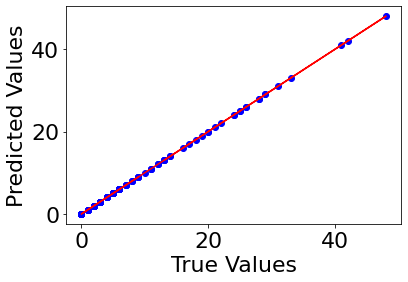

In [61]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

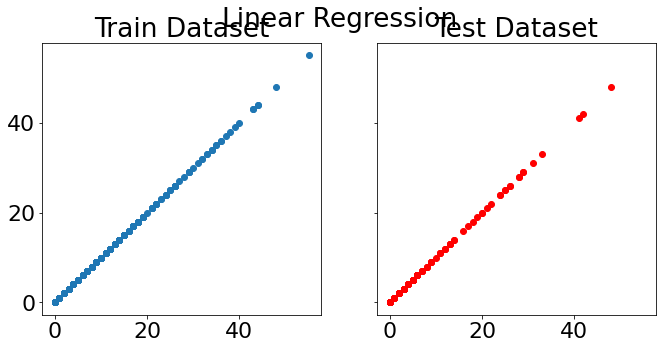

In [62]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [63]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.59719e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [64]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.0008087854850577225
MSE: 2.374394807157708e-06
RMSE: 0.0015409071377463692
R-squared score for train: 0.9999999796887477
Adjusted R-squared score for train: 0.999999978400717
R-squared score for test: 0.99999997493622
Adjusted R-squared score for test: 0.9999999733468095
Cross Validation Score: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.5972e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.25924e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.98945e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.16621e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99417e-17): result may not be accurate.

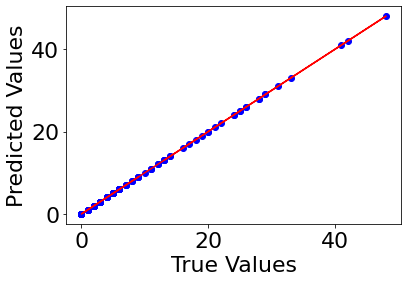

In [65]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

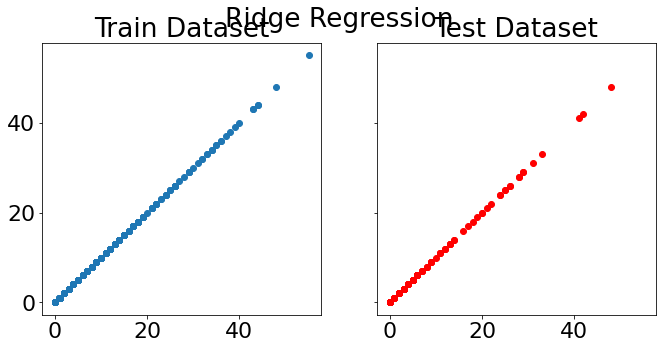

In [66]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [67]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
0,Daily Confirmed,9.998530e-01
35,Phase_=_Phase 3,1.234365e-03
30,Phase_=_Circuit Breaker,6.844772e-04
33,Phase_=_Phase 2,2.773164e-04
32,Phase_=_Phase 1,1.687674e-04
25,Perc population completed at least one dose,1.313172e-04
26,Perc population completed vaccination,1.179155e-04
2,Cumulative Confirmed,5.786138e-05
8,Daily Deaths,1.218967e-05
18,Total Hospital Discharged MOH report,6.797777e-06


In [68]:
# filter important features accordingly

important_X = X[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [69]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
ridge_pred = impt_ridge.predict(important_X_test)

In [70]:
train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 4.480547316419077
MSE: 58.67933809238528
RMSE: 7.660243996922374
R-squared score for train: 0.47657795321097496
Adjusted R-squared score for train: 0.4659625294851445
R-squared score for test: 0.3805891001693861
Adjusted R-squared score for test: 0.36802694463459984
Cross Validation Score: 0.4418


In [71]:
# XGBoost find best params

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.9,
 'min_child_weight': 2,
 'max_depth': 10,
 'colsample_bytree': 0.7}

In [72]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=10, colsample_bytree=0.7, min_child_weight=2)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 2.259758866925276
MSE: 13.094115973786561
RMSE: 3.6185792755978916
R-squared score for train: 0.9955495148478739
Adjusted R-squared score for train: 0.9954592553986108
R-squared score for test: 0.8617803400399628
Adjusted R-squared score for test: 0.8589771332077
Cross Validation Score: 0.8566


In [73]:
future_prediction = pd.DataFrame(data={
    "Daily Confirmed":[1000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Stabilisation Phase":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[1],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([9.586376], dtype=float32)

**Vaccination Rates**

In [74]:
X = sg_data_filtered.drop("Perc population completed vaccination", axis=1)
y = sg_data_filtered["Perc population completed vaccination"]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [76]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [77]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 0.0028701264892315396
MSE: 1.8922970026805695e-05
RMSE: 0.004350054025734128
R-squared score for train: 0.999824124686857
Adjusted R-squared score for train: 0.9998129716182187
R-squared score for test: 0.9998058083122788
Adjusted R-squared score for test: 0.9997934937174477
Cross Validation Score: 0.9997


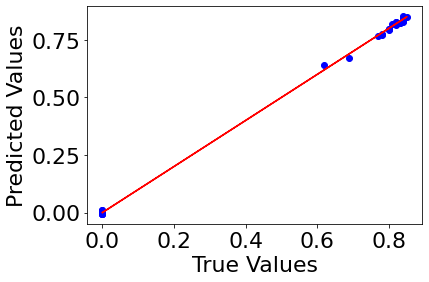

In [78]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

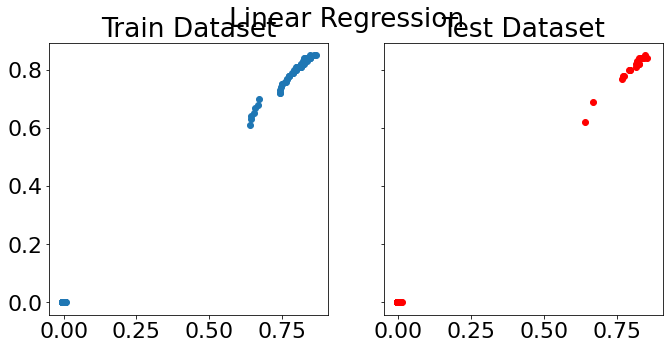

In [79]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [80]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.63676e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [81]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.008361977311680095
MSE: 0.0002249821770024093
RMSE: 0.014999405888314686
R-squared score for train: 0.9957259704522015
Adjusted R-squared score for train: 0.9954549344320972
R-squared score for test: 0.9976911833291823
Adjusted R-squared score for test: 0.9975447705646914
Cross Validation Score: 0.9944


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.63676e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.22312e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.57403e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.19916e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.04301e-17): result may not be accurate

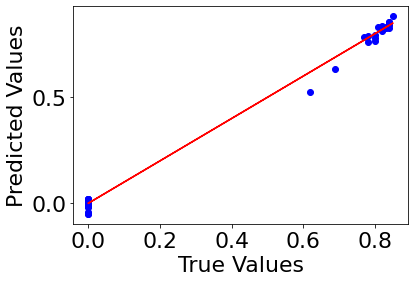

In [82]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

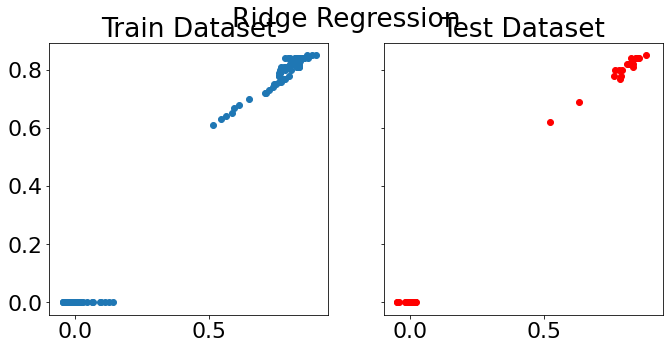

In [83]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [84]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
26,Perc population completed at least one dose,4.484703e-01
38,Phase_=_Stabilisation Phase,3.489993e-02
37,Phase_=_Preparatory Stage,2.119138e-02
27,Year,1.304377e-02
36,Phase_=_Phase 3 (Heightened Alert),9.228103e-03
9,Cumulative Deaths,4.018951e-03
5,Cumulative Discharged,3.255918e-03
6,Discharged to Isolation,3.199157e-03
7,Still Hospitalised,3.195312e-03
8,Daily Deaths,2.115375e-03


In [85]:
# filter important features accordingly

important_X = X[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [86]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [87]:
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.008950256992569372
MSE: 0.00025048366368509974
RMSE: 0.0158266756991195
R-squared score for train: 0.9973863969369045
Adjusted R-squared score for train: 0.9973124270388923
R-squared score for test: 0.997429481454091
Adjusted R-squared score for test: 0.9973567309292068
Cross Validation Score: 0.9964


In [88]:
# XGBoost find best params

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.9,
 'min_child_weight': 6,
 'max_depth': 5,
 'colsample_bytree': 0.9}

In [89]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=5, colsample_bytree=0.9, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 0.0006006941948676323
MSE: 5.905423930462124e-06
RMSE: 0.002430107802230618
R-squared score for train: 0.9999958570053857
Adjusted R-squared score for train: 0.9999957397508212
R-squared score for test: 0.999939397238481
Adjusted R-squared score for test: 0.9999376820659852
Cross Validation Score: 0.9999


In [90]:
future_prediction = pd.DataFrame(data={
    "Perc population completed at least one dose":[90],
    "Tested positive demise":[0],
    "Cumulative Deaths":[1200],
    "Discharged to Isolation":[90000],
    "Still Hospitalised":[3600],
    "Cumulative Discharged":[500000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[0],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[1]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([0.84130526], dtype=float32)

**ICU Occupancy**

In [91]:
X = sg_data_filtered.drop("Intensive Care Unit (ICU)", axis=1)
y = sg_data_filtered["Intensive Care Unit (ICU)"]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [93]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [94]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 2.085494263794817
MSE: 12.915801751227509
RMSE: 3.5938561116476975
R-squared score for train: 0.9641057519300213
Adjusted R-squared score for train: 0.9618295313207056
R-squared score for test: 0.9474116848259113
Adjusted R-squared score for test: 0.944076816058774
Cross Validation Score: 0.9497


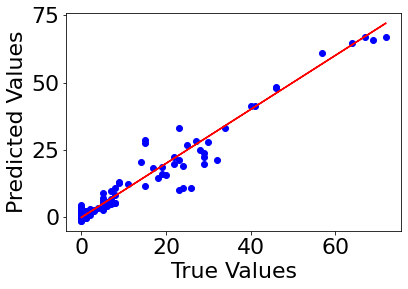

In [95]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

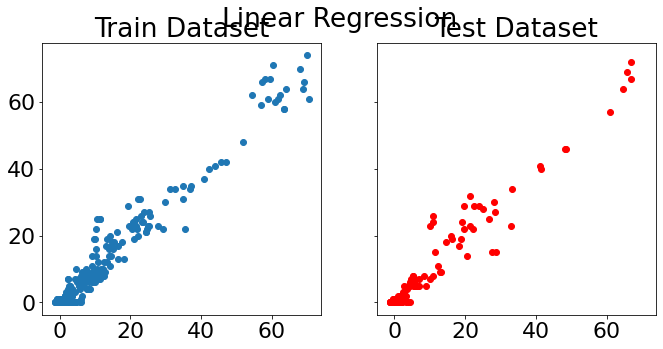

In [96]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [97]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.60569e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [98]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 2.078799914686994
MSE: 12.887651452862329
RMSE: 3.5899375277102425
R-squared score for train: 0.9633151297756738
Adjusted R-squared score for train: 0.9609887721516921
R-squared score for test: 0.9475263023147197
Adjusted R-squared score for test: 0.9441987019737019
Cross Validation Score: 0.9503


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.60569e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.14131e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.97626e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.18195e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99811e-17): result may not be accurate

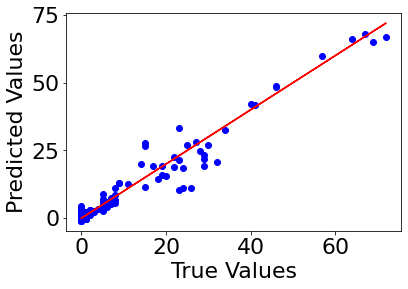

In [99]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

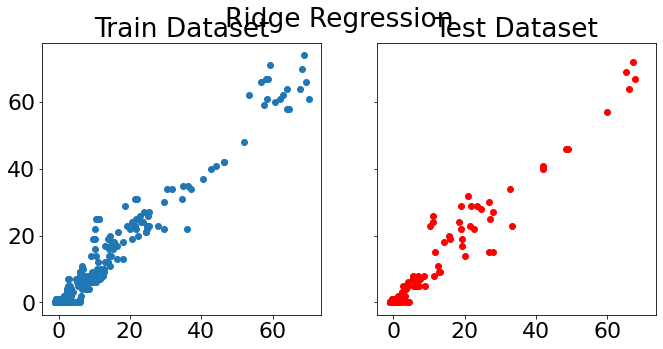

In [100]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [101]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
25,Perc population completed at least one dose,3.554217
30,Phase_=_Circuit Breaker,3.497757
26,Perc population completed vaccination,2.311058
38,Phase_=_Stabilisation Phase,1.743460
7,Still Hospitalised,1.615314
6,Discharged to Isolation,1.614174
9,Cumulative Deaths,1.550377
5,Cumulative Discharged,1.511003
4,Passed but not due to COVID,0.633428
10,Tested positive demise,0.571184


In [102]:
# filter important features accordingly

important_X = X[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [103]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [104]:
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 2.4709950939860525
MSE: 19.92162939005939
RMSE: 4.463365253937817
R-squared score for train: 0.9377163440022711
Adjusted R-squared score for train: 0.9357515599013964
R-squared score for test: 0.9188865743432254
Adjusted R-squared score for test: 0.9163277911994786
Cross Validation Score: 0.9293


In [105]:
# XGBoost find best params

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 6,
 'max_depth': 10,
 'colsample_bytree': 0.7}

In [106]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.8, max_depth=10, colsample_bytree=0.7, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 0.7814093830405187
MSE: 1.9219164747508202
RMSE: 1.386332021829843
R-squared score for train: 0.9989012536014455
Adjusted R-squared score for train: 0.998866592831775
R-squared score for test: 0.9921746747697746
Adjusted R-squared score for test: 0.9919278190842785
Cross Validation Score: 0.9916


In [107]:
future_prediction = pd.DataFrame(data={
    "Passed but not due to COVID":[0],
    "Tested positive demise":[0],
    "Cumulative Discharged":[500000],
    "Cumulative Deaths":[1200],
    "Discharged to Isolation":[90000],
    "Still Hospitalised":[3600],
    "Perc population completed vaccination":[90],
    "Perc population completed at least one dose":[91],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[0],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[1],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([63.224728], dtype=float32)

**Oxygen Supplementation**

In [108]:
X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [110]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [111]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 5.1461490916933785
MSE: 83.45280262468009
RMSE: 9.135250550733685
R-squared score for train: 0.99481144750173
Adjusted R-squared score for train: 0.9944824173433031
R-squared score for test: 0.9913060518366558
Adjusted R-squared score for test: 0.99075472829459
Cross Validation Score: 0.992


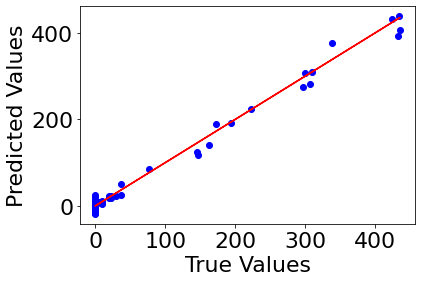

In [112]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

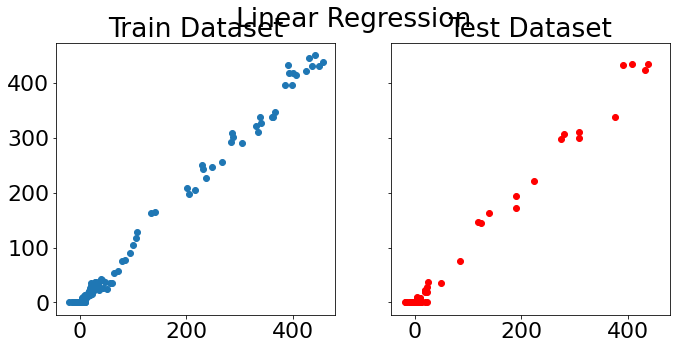

In [113]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [114]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.6014e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [115]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 5.166198693680397
MSE: 89.464959218771
RMSE: 9.45859182007401
R-squared score for train: 0.9930475034712294
Adjusted R-squared score for train: 0.9926066134474537
R-squared score for test: 0.9906797172363188
Adjusted R-squared score for test: 0.9900886749147194
Cross Validation Score: 0.9904


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.6014e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.18817e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.57802e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.16579e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99807e-17): result may not be accurate.

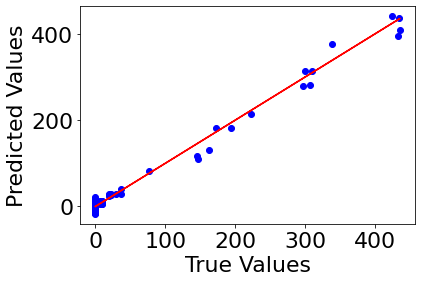

In [116]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

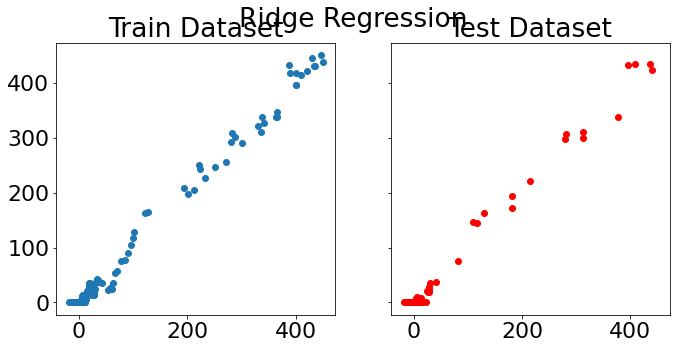

In [117]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [118]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
31,Phase_=_None,19.026477
38,Phase_=_Stabilisation Phase,16.093218
25,Perc population completed at least one dose,8.600352
7,Still Hospitalised,6.255993
6,Discharged to Isolation,6.252471
9,Cumulative Deaths,6.164208
5,Cumulative Discharged,6.101475
10,Tested positive demise,3.318000
33,Phase_=_Phase 2,2.634385
26,Perc population completed vaccination,1.491015


In [119]:
# filter important features accordingly

important_X = X[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [120]:
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [121]:
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 8.695504023803155
MSE: 301.6560744782791
RMSE: 17.36824903317197
R-squared score for train: 0.9840159841498322
Adjusted R-squared score for train: 0.983563606342752
R-squared score for test: 0.9685740659128388
Adjusted R-squared score for test: 0.9676846526839569
Cross Validation Score: 0.978


In [122]:
# XGBoost find best params

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 2,
 'max_depth': 10,
 'colsample_bytree': 0.8}

In [123]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.8, max_depth=10, colsample_bytree=0.8, min_child_weight=2)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 1.7554583053619117
MSE: 43.37403272721947
RMSE: 6.585896501405065
R-squared score for train: 0.9999748015241453
Adjusted R-squared score for train: 0.9999740883597343
R-squared score for test: 0.9954813789314954
Adjusted R-squared score for test: 0.9953534934295566
Cross Validation Score: 0.9961


In [124]:
future_prediction = pd.DataFrame(data={
    "Perc population completed at least one dose":[93],
    "Tested positive demise":[0],
    "Cumulative Deaths":[600],
    "Discharged to Isolation":[45000],
    "Still Hospitalised":[1800],
    "Cumulative Discharged":[250000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([448.0867], dtype=float32)